<a href="https://colab.research.google.com/github/talhaanwarch/IDDs_EEG_ML_classification/blob/master/Paper_rest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.biorxiv.org/content/10.1101/759738v1.full.pdf  
https://www.sciencedirect.com/science/article/pii/S2352340920303826  
https://data.mendeley.com/datasets/fshy54ypyh/1  

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip

--2020-06-25 05:58:28--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.42.8
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.42.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34220065 (33M) [application/octet-stream]
Saving to: ‘fshy54ypyh-1.zip’

fshy54ypyh-1.zip    100%[===================>]  32.63M  19.6MB/s    in 1.7s    

2020-06-25 05:58:30 (19.6 MB/s) - ‘fshy54ypyh-1.zip’ saved [34220065/34220065]



In [2]:
%%capture 
!unzip fshy54ypyh-1.zip

# Import packages

In [3]:
import scipy.io
from glob import glob
import numpy as np
from tqdm import tqdm
import pandas as pd


In [4]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import KFold,LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt


# Load data

In [5]:
IDD='/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD'
TDC='/content/Data/CleanData/CleanData_TDC'

In [6]:
!rm '/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD(1).mat'

In [7]:
IDD_rest=[]
for i in glob(IDD+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    IDD_rest.append(data )

TDC_rest=[]
for i in glob(TDC+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    TDC_rest.append(data )

# Plot wavelet Db4

In [8]:
x=scipy.io.loadmat(glob(IDD+'/Rest/*.mat')[0])['clean_data']
x.shape

(14, 15360)

In [9]:
TDC_rest[0].shape

(30, 14, 512)

In [10]:
import pywt
x_values=pywt.Wavelet('db4').wavefun(level=6)
#plt.plot(x_values[-1], wavelet_function[0])

In [11]:
len(x_values)

3

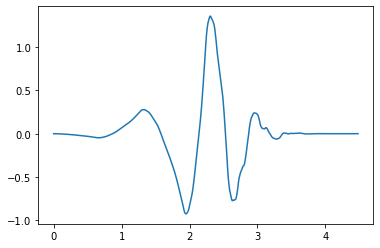

In [12]:
plt.plot(x_values[1])
#plt.xticks(np.arange(0,500,100))
plt.xticks(np.arange(0,500,100),[0,1,2,3,4])

plt.savefig('db4.eps',dip=300)

# Plot wavelet decomposition

In [13]:
x=IDD_rest[0][0][0]
x.shape

(512,)

In [14]:
coefs = pywt.wavedec(x, wavelet='db4', level=None)
len(coefs)

7

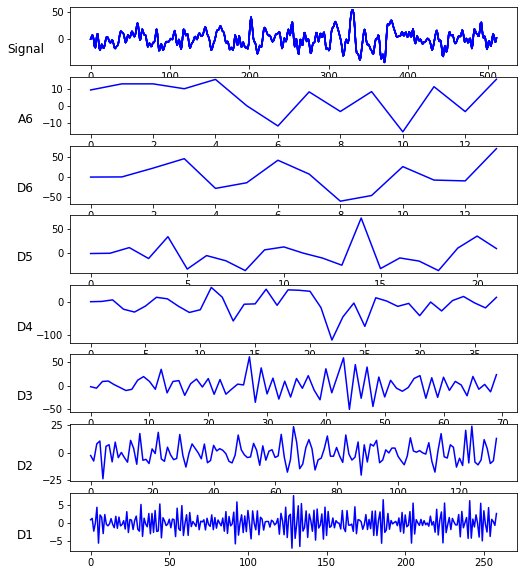

In [15]:
fig,ax=plt.subplots(nrows=8,ncols=1,figsize=(8,10))
label=['A6','D6','D5','D4','D3','D2','D1']
for i,l in zip(range(1,8),label):
  ax[0].plot(x,color='b')
  #ax[0].set_xticks([],[])
  ax[0].set_title('Signal',x=-0.1,y=0.1)
  ax[i].plot(coefs[i-1],color='b')
  ax[i].set_title(l,x=-0.1,y=0.1)
  #ax[i].set_xticks(np.arange(0,250,50))
#plt.subplots_adjust(wspace=0, hspace=0)

In [16]:
x=TDC_rest[0][0][0]
print(x.shape)
coefs = pywt.wavedec(x, wavelet='db4', level=None)
len(coefs)

(512,)


7

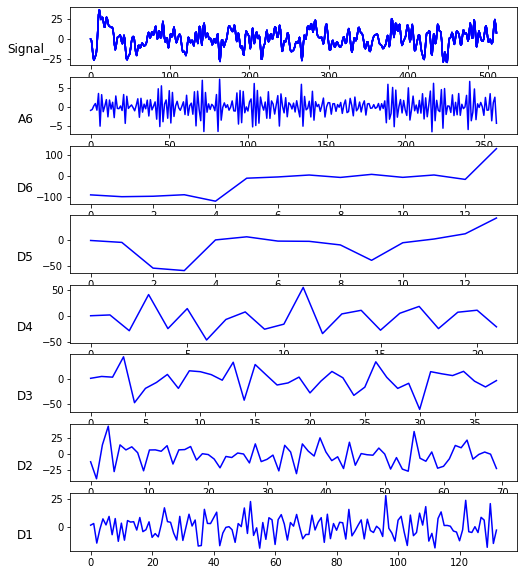

In [17]:
fig,ax=plt.subplots(nrows=8,ncols=1,figsize=(8,10))
label=['A6','D6','D5','D4','D3','D2','D1']
for i,l in zip(range(8),label):
  ax[0].plot(x,color='b')
  #ax[0].set_xticks([],[])
  ax[0].set_title('Signal',x=-0.1,y=0.1)
  ax[i+1].plot(coefs[i-1],color='b')
  ax[i+1].set_title(l,x=-0.1,y=0.1)
#plt.subplots_adjust(wspace=0, hspace=0)

# Calcualte Features

In [18]:
import pywt

def wavelet_coefs(data,func, wavelet_name='db4'):
  coefs = pywt.wavedec(data, wavelet=wavelet_name, level=None)
  n_channels, n_times = data.shape
  levdec = len(coefs) - 1

  wavelet_energy = np.zeros((n_channels, levdec))
  for j in range(n_channels):
    for l in range(levdec):
      if func=='energy':
        wavelet_energy[j, l] = np.sum(coefs[levdec - l][j, :] ** 2)
      else:
        wavelet_energy[j, l] = func(coefs[levdec - l][j, :])
  return wavelet_energy.ravel()

In [19]:
def calculate_features(func):
  features1=[]
  features2=[]
  for k in tqdm(range(7)):
    feature1=[]
    feature2=[]
    for i in range(30):  
      feature1.append(wavelet_coefs(IDD_rest[k][i],func=func))
      feature2.append(wavelet_coefs(TDC_rest[k][i],func=func))
    features1.append(np.array(feature1))
    features2.append(np.array(feature2))
  x1=np.array(features1)        
  x2=np.array(features2) 
  y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
  X=np.concatenate((x1,x2),axis=0)
  return X,y

In [20]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    #xgb.XGBClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [21]:
def classifiers_calc(X,y):
  accuracy_avg=[]
  accuracy_std=[]
  f1_avg=[]
  f1_std=[]
  for clfs in classifiers:
      # print('====================================')
      # name = clfs.__class__.__name__
      # print(name)
      acc_scores=[]
      f1_scores=[]
      for train,test in StratifiedKFold(7).split(X,y):
        X_train=X[train].reshape(-1,X.shape[2])
        X_test=X[test].reshape(-1,X.shape[2])
        y_train=np.concatenate([[i]*X.shape[1] for i in y[train]])
        y_test=np.concatenate([[i]*X.shape[1] for i in y[test]])
        sc=StandardScaler()
        X_train=sc.fit_transform(X_train)
        X_test=sc.transform(X_test)
        X_train, y_train = shuffle(X_train, y_train)
        
        clfs.fit(X_train,y_train)
        y_pred=clfs.predict(X_test)
        acc_scores.append(accuracy_score(y_test,y_pred))
        f1_scores.append(f1_score(y_test,y_pred))
      accuracy_avg.append(np.mean(acc_scores))
      accuracy_std.append(np.std(acc_scores))
      f1_avg.append(np.mean(f1_scores))
      f1_std.append(np.std(f1_scores))
  return accuracy_avg,accuracy_std,f1_avg,f1_std

In [22]:
 classifier=['KNN','c-SVM','nu-SVM','DT','RF','AB','GB','NB','LDA','QDA','LR']
def plot_classifiers(accuracy_avg,f1_avg,title):
 
  y_pos = np.arange(len(classifier))
  w=0.4
  plt.figure(figsize=(10,5))
  plt.bar(y_pos,np.array(accuracy_avg),align='center',width=w,label='Accuracy')
  plt.bar(y_pos+w,np.array(f1_avg),align='center',width=w,label='F1-score')
  ya=np.array(accuracy_avg)
  for index, value in enumerate(ya):
      plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=11)

  yf=np.array(f1_avg)
  for index, value in enumerate(yf):
      plt.text(index+w-0.1,value-0.1, str(np.round(value,2)),rotation=90,color='white',fontsize=11)


  plt.xticks(y_pos, classifier,fontsize=11)
  plt.yticks(fontsize=11)

  plt.ylabel('Score',fontsize=12)
  plt.xlabel('Classifiers',fontsize=12)
  plt.title('Classifiers Performance of {} Coefficents Features'.format(title),fontsize=12)
  plt.legend()
  plt.savefig('{} Feature.eps'.format(title),dip=300)

## Plot classifiers performance

## Average coefficents

In [23]:
X,y=calculate_features(np.mean)

100%|██████████| 7/7 [00:00<00:00, 13.18it/s]


In [24]:
meanFeatureAcc,meanFeatureAccStd,meanFeatureF1,meanFeatureF1Std=classifiers_calc(X,y) #average k fold cross validation of mean features extracted from wavelet coefficient

In [25]:
df=pd.DataFrame(zip(meanFeatureAcc,meanFeatureAccStd,meanFeatureF1,meanFeatureF1Std)).round(4)*100
df.columns=['Acc Avg', 'Acc Std.','F1 Avg', 'F1 Std.']
mean_df=df.rename(index=dict(zip(list(range(0,11)),classifier)))
mean_df

,Acc Avg,Acc Std.,F1 Avg,F1 Std.
KNN,69.29,10.98,77.02,6.87
c-SVM,76.90,19.69,76.82,20.94
nu-SVM,81.43,20.38,81.16,22.05
DT,64.76,11.46,64.44,11.01
RF,77.62,12.53,76.38,13.49
AB,40.24,10.14,39.68,13.05
GB,86.90,7.26,88.03,5.69
NB,45.48,9.95,8.76,11.80
LDA,51.90,1.87,54.24,2.60
QDA,91.90,9.36,89.86,13.11


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


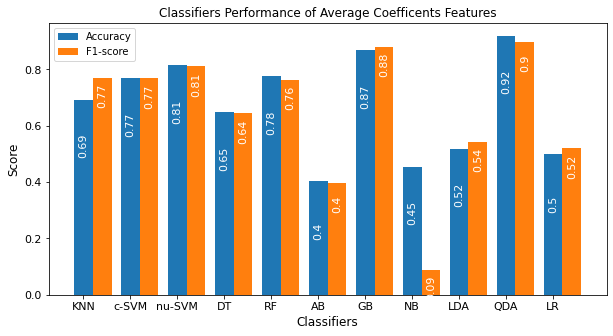

In [26]:
plot_classifiers(meanFeatureAcc,meanFeatureF1,title='Average')